Parent directory added to sys.path: /Users/ivan/Desktop/AP4Fed/Local


/var/folders/9j/10v9ngt92ts7snck5_jqsz1m0000gn/T/ipykernel_48997/3659846197.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_pat

Files already downloaded and verified


  0%|          | 0/1000 [00:00<?, ?it/s]

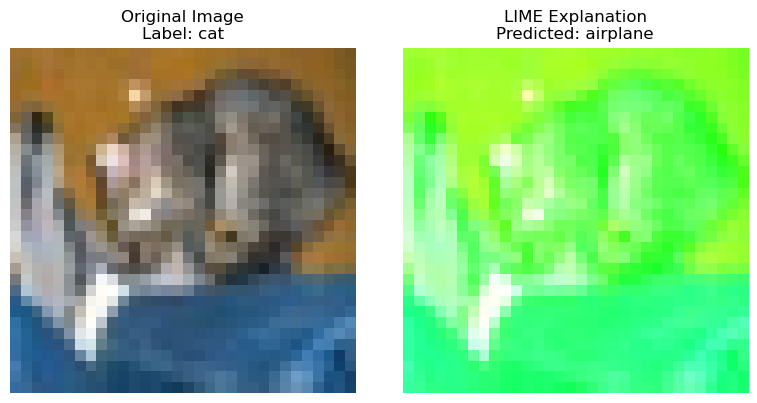

In [22]:
import sys
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import torchvision.datasets as datasets

if '__file__' in globals():
    current_dir = os.path.dirname(os.path.abspath(__file__))
else:
    current_dir = os.getcwd()

parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
print("Parent directory added to sys.path:", parent_dir)

from taskA import Net as NetA

CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

weights_path = os.path.join("server", "MW_round1.pt")
model = NetA()
model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
model.eval()

def new_forward(x):
    x = model.pool(F.relu(model.conv1(x)))
    x = model.pool(F.relu(model.conv2(x)))
    x = x.reshape(-1, 16 * 5 * 5)
    x = F.relu(model.fc1(x))
    x = F.relu(model.fc2(x))
    return model.fc3(x)

model.forward = new_forward

# 2. Define the prediction function for LIME.
def predict_fn(images):
    # images come in shape (batch, H, W, C); convert to (batch, C, H, W)
    images = np.transpose(images, (0, 3, 1, 2))
    images_tensor = torch.from_numpy(images).float() / 255.0  # Normalize to [0,1]
    with torch.no_grad():
        logits = model(images_tensor)
        probabilities = F.softmax(logits, dim=1).cpu().numpy()
    return probabilities

# 3. Load an image from the CIFAR-10 dataset.
#    We use torchvision.datasets to download/load the dataset if necessary.
testset = datasets.CIFAR10(root="./data", train=False, download=True)
img, label = testset[0]
# Convert the PIL image to a NumPy array (shape: 32x32x3, uint8)
image_rgb = np.array(img)

# 4. Initialize the LIME explainer for images.
explainer = lime_image.LimeImageExplainer()

# 5. Generate the explanation.
#    num_samples=1000 is often enough, but you can adjust it if you need a more accurate explanation.
explanation = explainer.explain_instance(
    image_rgb,
    classifier_fn=predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

# Pick the top predicted label from the explanation
top_label = explanation.top_labels[0]

# 6. Get the mask and temp image with both positive and negative contributions, and do not hide the rest.
#    Increase num_features to highlight more superpixels (e.g., 10).
temp, mask = explanation.get_image_and_mask(
    label=top_label,
    positive_only=False,   # show both positive (green) and negative (red) contributions
    num_features=10,       # highlight up to 10 superpixels
    hide_rest=False        # do not hide the rest of the image
)

# Normalize temp to [0,1] for display
temp_display = np.clip(temp, 0, 255) / 255.0

# 7. Visualize the results side by side.
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title(f"Original Image\nLabel: {CLASS_NAMES[label]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp_display, mask))
plt.title(f"LIME Explanation\nPredicted: {CLASS_NAMES[top_label]}")
plt.axis("off")
plt.tight_layout()
plt.show()